# 04 — Regression (Supervised) for PM2.5 (Tabular Time-Lag Features)
Mục tiêu:
- Biến bài toán chuỗi thời gian thành bài toán **hồi quy có giám sát**: dự đoán PM2.5(t+h) từ đặc trưng tại thời điểm t.
- Thấy rõ: **leakage** và vì sao phải split theo thời gian.
- So sánh tư duy hồi quy (feature-based) vs ARIMA (time-series-based).


In [1]:
import os
os.makedirs('images', exist_ok=True)
from pathlib import Path

# ===== PARAMETERS =====
USE_UCIMLREPO = False

# Path to the raw ZIP (relative to project root)
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

def resolve_project_root(raw_zip_rel: str) -> Path:
    """Resolve project root robustly for both Jupyter and Papermill runs."""
    cwd = Path.cwd().resolve()
    candidates = [cwd, cwd.parent]
    root = cwd
    for _ in range(3):
        candidates.append(root)
        root = root.parent
    for r in candidates:
        if (r / raw_zip_rel).exists():
            return r
    return cwd

PROJECT_ROOT = resolve_project_root(RAW_ZIP_PATH)
RAW_ZIP_ABS = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())

LAG_HOURS = [1, 3, 24]
HORIZON = 1
TARGET_COL = 'PM2.5'
OUTPUT_REG_DATASET_PATH = 'data/processed/dataset_for_regression.parquet'
CUTOFF = '2017-01-01'
MODEL_OUT = 'regressor.joblib'
METRICS_OUT = 'regression_metrics.json'
PRED_SAMPLE_OUT = 'regression_predictions_sample.csv'


In [2]:
# Parameters
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
LAG_HOURS = [1, 3, 24]
HORIZON = 1
TARGET_COL = "PM2.5"
OUTPUT_REG_DATASET_PATH = "data/processed/dataset_for_regression.parquet"
CUTOFF = "2017-01-01"
MODEL_OUT = "regressor.joblib"
METRICS_OUT = "regression_metrics.json"
PRED_SAMPLE_OUT = "regression_predictions_sample.csv"


In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.classification_library import Paths
from src.regression_library import run_prepare_regression_dataset, run_train_regression
paths = Paths(project_root=PROJECT_ROOT)
print('PROJECT_ROOT =', PROJECT_ROOT)
print('RAW_ZIP_ABS =', RAW_ZIP_ABS)


PROJECT_ROOT = E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries
RAW_ZIP_ABS = E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\raw\PRSA2017_Data_20130301-20170228.zip


## 1) Tạo dataset hồi quy (lag features + time features + y = PM2.5(t+h))


In [4]:
out_path = run_prepare_regression_dataset(
    paths=paths,
    use_ucimlrepo=USE_UCIMLREPO,
    raw_zip_path=RAW_ZIP_ABS,
    lag_hours=LAG_HOURS,
    horizon=HORIZON,
    target_col=TARGET_COL,
)
print('Saved:', out_path)


Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirQuality_TimeSeries\data\processed\dataset_for_regression.parquet


## 2) Quick EDA cho dataset hồi quy


(420768, 57)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24,y
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


CO_lag24     0.049849
CO_lag3      0.049284
CO_lag1      0.049227
CO           0.049198
O3_lag24     0.032203
O3_lag3      0.031640
O3_lag1      0.031583
O3           0.031554
NO2_lag24    0.029446
NO2_lag3     0.028881
NO2_lag1     0.028823
NO2          0.028795
SO2_lag24    0.022091
SO2_lag3     0.021525
SO2_lag1     0.021468
dtype: float64

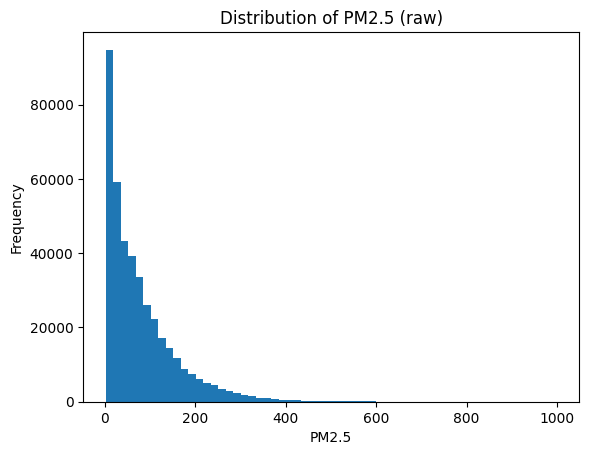

In [5]:
ds_path = (PROJECT_ROOT / OUTPUT_REG_DATASET_PATH).resolve()
df = pd.read_parquet(ds_path)
print(df.shape)
display(df.head())
missing = df.isna().mean().sort_values(ascending=False).head(15)
display(missing)
plt.figure()
pd.Series(df[TARGET_COL]).dropna().plot(kind='hist', bins=60)
plt.title(f'Distribution of {TARGET_COL} (raw)')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.savefig('images/regression_target_dist.png')
plt.show()


## 3) Train/Test theo thời gian + train regressor


Metrics:
{
  "n_train": 395301,
  "n_test": 16716,
  "rmse": 25.32672696176382,
  "mae": 12.32315830517231,
  "smape_pct": 23.837711259945237,
  "r2": 0.9491508772105639,
  "feature_cols": [
    "No",
    "year",
    "month",
    "day",
    "hour",
    "PM2.5",
    "PM10",
    "SO2",
    "NO2",
    "CO",
    "O3",
    "TEMP",
    "PRES",
    "DEWP",
    "RAIN",
    "wd",
    "WSPM",
    "station",
    "hour_sin",
    "hour_cos",
    "dow",
    "is_weekend",
    "PM2.5_lag1",
    "PM10_lag1",
    "SO2_lag1",
    "NO2_lag1",
    "CO_lag1",
    "O3_lag1",
    "TEMP_lag1",
    "PRES_lag1",
    "DEWP_lag1",
    "RAIN_lag1",
    "WSPM_lag1",
    "PM2.5_lag3",
    "PM10_lag3",
    "SO2_lag3",
    "NO2_lag3",
    "CO_lag3",
    "O3_lag3",
    "TEMP_lag3",
    "PRES_lag3",
    "DEWP_lag3",
    "RAIN_lag3",
    "WSPM_lag3",
    "PM2.5_lag24",
    "PM10_lag24",
    "SO2_lag24",
    "NO2_lag24",
    "CO_lag24",
    "O3_lag24",
    "TEMP_lag24",
    "PRES_lag24",
    "DEWP_lag24",
    "RAIN_lag24",

,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,477.0,436.901040
1,2017-01-01 01:00:00,Aotizhongxin,454.0,444.198916
2,2017-01-01 02:00:00,Aotizhongxin,418.0,433.323668
3,2017-01-01 03:00:00,Aotizhongxin,438.0,371.884739
4,2017-01-01 04:00:00,Aotizhongxin,453.0,464.841039


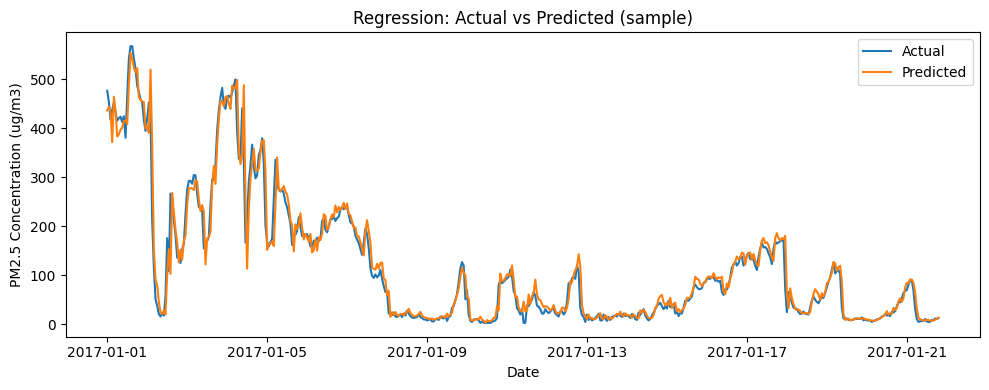

In [6]:
out = run_train_regression(
    paths=paths,
    cutoff=CUTOFF,
    model_out=MODEL_OUT,
    metrics_out=METRICS_OUT,
    preds_out=PRED_SAMPLE_OUT,
)
print('Metrics:')
print(json.dumps(out['metrics'], ensure_ascii=False, indent=2))
pred_df = out['pred_df']
display(pred_df.head())
# Plot a small window for storytelling
sample = pred_df.dropna().iloc[:500].copy()
plt.figure(figsize=(10,4))
plt.plot(sample['datetime'], sample['y_true'], label='Actual')
plt.plot(sample['datetime'], sample['y_pred'], label='Predicted')
plt.title('Regression: Actual vs Predicted (sample)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.legend()
plt.tight_layout()
plt.savefig('images/regression_pred_sample.png')
plt.show()


# Q2: Regression Baseline Analysis
**Thực hành Q2:**
1. **Ý nghĩa Lag 24h**: Do đặc tính sinh hoạt hàng ngày (giờ cao điểm, thấp điểm lặp lại) và chu kỳ thời tiết (ngày/đêm) nên PM2.5 thường có tương quan mạnh với chính nó cách đây 24h.
2. **Cutoff vs Shuffle**: Dữ liệu chuỗi thời gian có tính thứ tự. Shuffle sẽ gây **leakage** (mô hình học từ tương lai để dự đoán quá khứ gần). Cutoff đảm bảo mô hình chỉ biết dữ liệu lịch sử.
3. **RMSE vs MAE**: RMSE phạt nặng các sai số lớn (outliers/spikes), MAE đánh giá trung bình sai số tuyệt đối. Khi RMSE >> MAE, chứng tỏ mô hình dự báo sai lệch nhiều ở các điểm đột biến (spike).

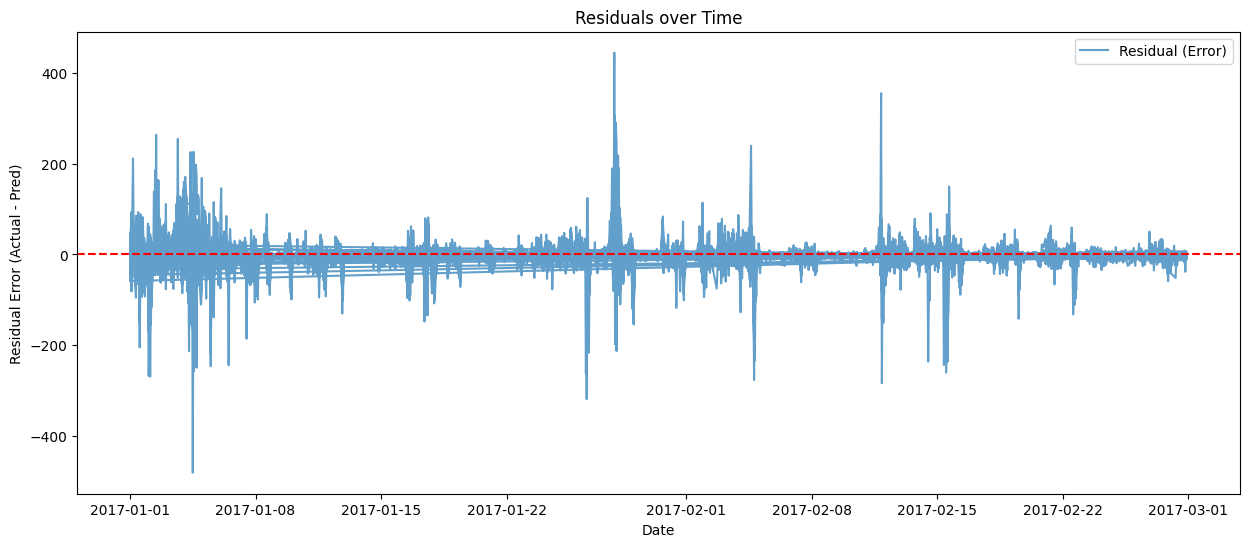

Top 5 worst predictions:


,datetime,station,y_true,y_pred,error
15413,2017-01-04 12:00:00,Wanshouxigong,3.0,483.563601,-480.563601
8993,2017-01-28 00:00:00,Huairou,556.0,111.790571,444.209429
10748,2017-02-11 21:00:00,Nongzhanguan,529.0,173.770681,355.229319
4816,2017-01-26 11:00:00,Dongsi,3.0,321.400999,-318.400999
15976,2017-01-28 00:00:00,Wanshouxigong,804.0,497.527289,306.472711


In [7]:
# Plotting errors to enable visual analysis
if 'pred_df' in locals():
    pred_df['error'] = pred_df['y_true'] - pred_df['y_pred']
    plt.figure(figsize=(15, 6))
    plt.plot(pred_df['datetime'], pred_df['error'], label='Residual (Error)', alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residuals over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual Error (Actual - Pred)')
    plt.legend()
    plt.savefig('images/regression_residuals.png')
    plt.show()
    
    # Check specific large error points
    worst_errors = pred_df.iloc[pred_df['error'].abs().argsort()[::-1]].head(5)
    print("Top 5 worst predictions:")
    display(worst_errors)